First We need load our dataset. This is same as previous notebook

In [79]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df_test = pd.read_csv('./dataset/test.csv')

scaler_r = MinMaxScaler()
scaler_c = MinMaxScaler()

scaler_r.fit(df_test[['registered']])
scaler_c.fit(df_test[['casual']])


df_test['registered_s'] = scaler_r.transform(df_test[['registered']])
df_test['casual_s'] = scaler_c.transform(df_test[['casual']])

df_test.drop(['Unnamed: 0','casual','registered'],axis=1,inplace=True)

import numpy as np


def create_dataset(data, feature_columns, target_columns, lookback_window, horizon, shift):
    """
    Transforms a time series DataFrame into input-target pairs for a deep learning model.

    Args:
        data (pd.DataFrame): The input DataFrame.
        feature_columns (list): List of column names to use as input features (X).
        target_columns (list): List of column names to use as target variables (Y).
        lookback_window (int): The number of past time steps to use as input (X).
        horizon (int): The number of future time steps to predict (Y).
        shift (int): The number of steps to shift the window for each new sample.

    Returns:
        tuple: A tuple containing two NumPy arrays, X (inputs) and Y (targets).
    """
    X, Y = [], []
    for i in range(0, len(data) - lookback_window - horizon + 1, shift):
        # Extract the input features (X) for the current window
        x_start = i
        x_end = i + lookback_window
        X.append(data.iloc[x_start:x_end][feature_columns].values)

        # Extract the target variables (Y) for the forecast horizon
        y_start = i + lookback_window
        y_end = y_start + horizon
        Y.append(data.iloc[y_start:y_end][target_columns].values)
    
    return np.array(X), np.array(Y)



We need to import config file which contains parameters and variable we will be using

In [80]:
import yaml

def load_config(filepath):
    """
    Loads a YAML configuration file from the specified filepath.

    Args:
        filepath (str): The path to the YAML file.

    Returns:
        dict: The configuration as a dictionary.
    """
    try:
        with open(filepath, 'r') as file:
            config = yaml.safe_load(file)
        return config
    except FileNotFoundError:
        print(f"Error: The file at {filepath} was not found.")
        return None
    except yaml.YAMLError as exc:
        print(f"Error parsing YAML file: {exc}")
        return None

# Load the configuration from the YAML file
config_file = 'config.yaml'
model_config = load_config(config_file)

In [81]:
#  Define key parameters
LOOKBACK_WINDOW = model_config['dataset']['lookback_window']  
FORECAST_HORIZON = model_config['dataset']['forecast_horizon'] 
SHIFT = model_config['dataset']['shift']          
# ----------------------------------------------------
# The columns model use to learn the patterns.

feature_columns = model_config['data']['feature_columns']

# The columns model will try to predict.
target_columns = model_config['data']['target_columns']

X_test, Y_test = create_dataset(df_test, feature_columns, target_columns, LOOKBACK_WINDOW, FORECAST_HORIZON, SHIFT)


In [82]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch Tensors
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(Y_test)

test_dataset = TensorDataset(X_test, y_test)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Now we will start evaluations

In [83]:
import torch
import torch.nn as nn
from model import LSTMForecaster,CNN_LSTMForecaster

BATCH_SIZE = model_config['model']['batch_size']
LOOKBACK_WINDOW = model_config['dataset']['lookback_window']  
NUM_FEATURES = model_config['model']['num_features']
FORECAST_HORIZON = model_config['dataset']['forecast_horizon'] 
NUM_TARGETS = model_config['model']['num_targets']

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_1 = LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=64,
        num_layers=1,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )

model_2 = CNN_LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=64,
        num_layers=1,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )


try:
    model_1.load_state_dict(torch.load('models/lstm_7f_rec_best.pth', map_location=device))
    model_2.load_state_dict(torch.load('models/cnn_lstm_7f_rec_best.pth', map_location=device))
    print("Successfully loaded models.")
except FileNotFoundError:
    print("Error: 'best_model.pth' not found. Please train the model first.")
   

RuntimeError: Error(s) in loading state_dict for CNN_LSTMForecaster:
	size mismatch for cnn.0.weight: copying a param with shape torch.Size([64, 7, 3]) from checkpoint, the shape in current model is torch.Size([64, 7, 7]).

In [ ]:
from tqdm import tqdm

def evaluate_model(model, test_loader, loss_fn, casual_scaler, registered_scaler, device='cpu'):
    """
    Evaluates the model on the test set and returns predictions and actual values.

    Args:
        model (nn.Module): The trained forecasting model.
        test_loader (DataLoader): DataLoader for the test data.
        loss_fn (nn.Module): The loss function (e.g., MSELoss).
        casual_scaler: The scaler fitted on the casual count training data.
        registered_scaler: The scaler fitted on the registered count training data.
        device (str): The device to run the evaluation on ('cpu' or 'cuda').

    Returns:
        tuple: A tuple containing denormalized predictions and actual values.
    """
    model.eval()
    model.to(device)
    
    test_loss = 0.0
    all_preds_scaled, all_actuals_scaled = [], []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs,targets = batch
            inputs=inputs.to(device)
            targets=targets.to(device)

            output = model(inputs)
            
            loss = loss_fn(output, targets)
            test_loss += loss.item() * targets.size(0)
            
            all_preds_scaled.append(output.cpu().numpy())
            all_actuals_scaled.append(targets.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"\nAverage Test Loss (Scaled MSE): {avg_test_loss:.4f}")

    print('outputs shape: ', output.shape)
    print("This should be Batch x Horizon x Feature")
    # Concatenate all batches
    all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
    all_actuals_scaled = np.concatenate(all_actuals_scaled, axis=0)
    print('Concatenated shape: ', all_preds_scaled.shape)
    # Denormalize the predictions and actuals
    # Note: We need to reshape for the scaler, then reshape back
    
    # Denormalize Casual predictions and actuals
    casual_preds_scaled = all_preds_scaled[:, :, 0]
    casual_preds = casual_scaler.inverse_transform(casual_preds_scaled.reshape(-1, 1)).reshape(casual_preds_scaled.shape)
    
    casual_actuals_scaled = all_actuals_scaled[:, :, 0]
    casual_actuals = casual_scaler.inverse_transform(casual_actuals_scaled.reshape(-1, 1)).reshape(casual_actuals_scaled.shape)
    
    # Denormalize Registered predictions and actuals
    registered_preds_scaled = all_preds_scaled[:, :, 1]
    registered_preds = registered_scaler.inverse_transform(registered_preds_scaled.reshape(-1, 1)).reshape(registered_preds_scaled.shape)
    
    registered_actuals_scaled = all_actuals_scaled[:, :, 1]
    registered_actuals = registered_scaler.inverse_transform(registered_actuals_scaled.reshape(-1, 1)).reshape(registered_actuals_scaled.shape)
    print('After Transform rgistered shape: ', registered_actuals_scaled.shape)
    return (casual_preds, registered_preds), (casual_actuals, registered_actuals)


In [ ]:
preds_1, actuals_1 = evaluate_model(
        model=model_1,
        test_loader=test_loader,
        loss_fn=nn.L1Loss(),
        casual_scaler=scaler_c,
        registered_scaler=scaler_r,
        device=device
    )

Testing: 100%|██████████| 49/49 [00:00<00:00, 166.70it/s]


Average Test Loss (Scaled MSE): 0.0633
outputs shape:  torch.Size([12, 24, 2])
This should be Batch x Horizon x Feature
Concatenated shape:  (1548, 24, 2)
After Transform rgistered shape:  (1548, 24)


In [ ]:
preds_2, actuals_2 = evaluate_model(
        model=model_2,
        test_loader=test_loader,
        loss_fn=nn.L1Loss(),
        casual_scaler=scaler_c,
        registered_scaler=scaler_r,
        device=device
    )

Testing: 100%|██████████| 49/49 [00:00<00:00, 219.14it/s]


Average Test Loss (Scaled MSE): 0.0626
outputs shape:  torch.Size([12, 24, 2])
This should be Batch x Horizon x Feature
Concatenated shape:  (1548, 24, 2)
After Transform rgistered shape:  (1548, 24)


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(preds, actuals, sample_indices=[0,1,2,3], title="Prediction vs. Actuals"):
    """
    Plots the predicted vs. actual values for a specific test sample.
    """
    
    plt.figure(figsize=(12, 6))
    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    fig.suptitle(title, fontsize=14, fontweight='bold')
    for i in range(2):
        for j in range(4):
            ax = axs[i, j]
            ax.plot(actuals[i][sample_indices[j]], color='blue', marker='o')
            ax.plot(preds[i][sample_indices[j]], color='red', linestyle='--', marker='x')
            ax.set_title(f'Sample: {sample_indices[j]}', fontsize=10)
            ax.grid(True)
    _ = fig.text(0.5, 0.92, 'Casual Users', ha='center', va='center', fontsize=12)
    _ = fig.text(0.5, 0.47, 'Registered Users', ha='center', va='center', fontsize=12)

    # Plot Casual users
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
preds = [preds_1,preds_2]
actuals= [actuals_1,actuals_2]


--- Model Performance on Test Set (Denormalized) ---
Casual Users - MAE: 22.73
Registered Users - MAE: 53.46


<Figure size 1200x600 with 0 Axes>

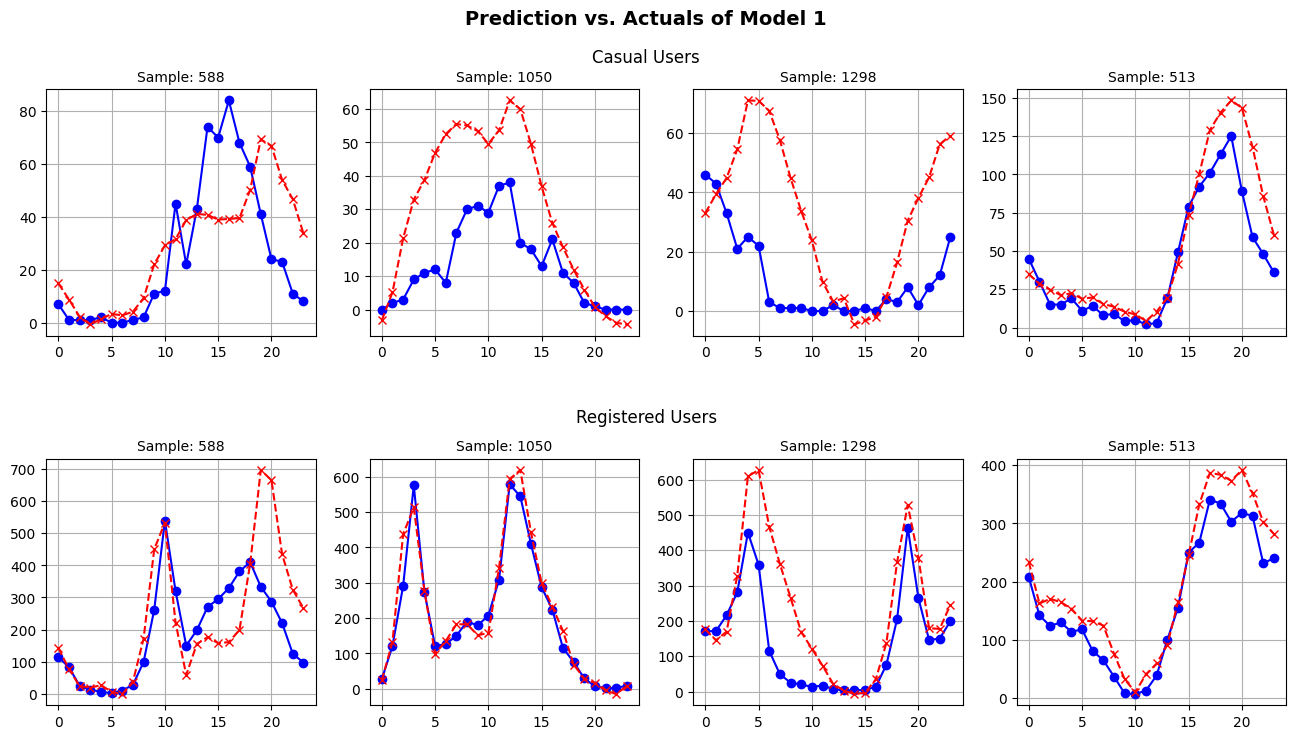


--- Model Performance on Test Set (Denormalized) ---
Casual Users - MAE: 22.85
Registered Users - MAE: 52.06


<Figure size 1200x600 with 0 Axes>

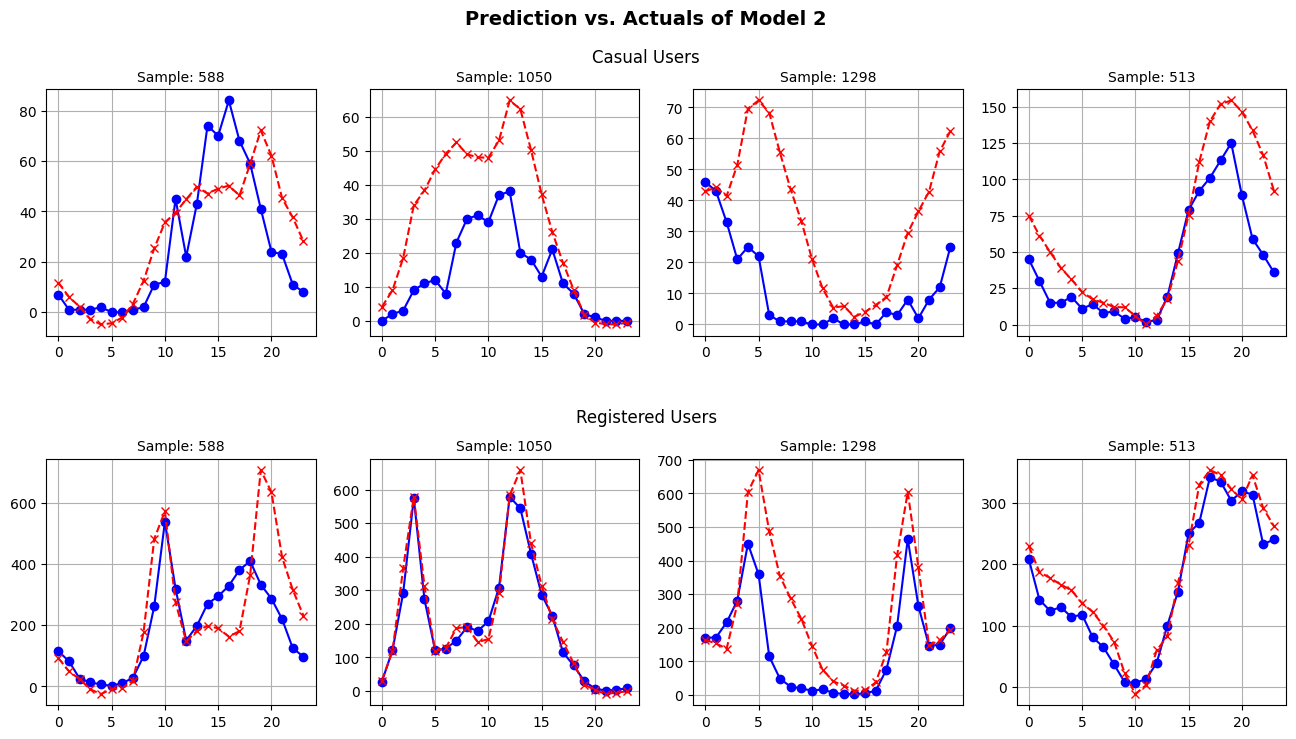

In [ ]:
from sklearn.metrics import mean_absolute_error


indices = np.random.randint(1, 1500, 4).tolist()

for i in range(2):
    # Reshape to a 1D array for metric calculation
    casual_preds_flat = preds[i][0].flatten()
    casual_actuals_flat = actuals[i][0].flatten()
    registered_preds_flat = preds[i][1].flatten()
    registered_actuals_flat = actuals[i][1].flatten()

    casual_mae = mean_absolute_error(casual_actuals_flat, casual_preds_flat)

    registered_mae = mean_absolute_error(registered_actuals_flat, registered_preds_flat)

    print("\n--- Model Performance on Test Set (Denormalized) ---")
    print(f"Casual Users - MAE: {casual_mae:.2f}")
    print(f"Registered Users - MAE: {registered_mae:.2f}")

    
# You can change the index to view different samples
    # plot_predictions(           
    #     preds=preds[i],          
    #     actuals=actuals[i],
    #     sample_indices=indices, # should send exactly 4 indices
    #     title="Prediction vs. Actuals of Model "+str(i+1)
    #     )



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from models import CNN_LSTMForecaster

def predict_future(model, input_sequence, forecast_horizon, device='cpu'):
    """
    Performs multi-step forecasting using a recursive strategy.

    Args:
        model (nn.Module): The trained model.
        input_sequence (torch.Tensor): The initial input sequence (lookback_window).
        forecast_horizon (int): The number of future time steps to predict.
        device (str): The device to run on.

    Returns:
        torch.Tensor: The full sequence of future predictions.
    """
    model.eval()
    model.to(device)
    
    # Clone the initial input sequence to avoid modifying the original data
    current_input = input_sequence.clone().detach().to(device)
    
    # Store all future predictions
    future_predictions = []
    
    with torch.no_grad():
        # The number of steps is based on your model's forecast horizon (e.g., 3 hours)
        num_recursive_steps = forecast_horizon // 3
        
        # Get the number of features and targets from the input sequence
        # We assume the last 2 features are the targets (casual_s, registered_s)
        num_targets = 2
        
        for _ in range(num_recursive_steps):
            # Get the model's 3-hour forecast
            prediction_scaled = model(current_input)
            
            # The prediction is of shape (batch_size, 3, num_targets)
            # We will take the first sample's prediction (batch size of 1)
            prediction_scaled_squeezed = prediction_scaled.squeeze(0).cpu()
            
            future_predictions.append(prediction_scaled_squeezed)
            
            # Prepare the next input sequence
            # Create a new tensor with a size that matches the lookback window
            new_input = torch.zeros_like(current_input)
            
            # Copy all but the first `FORECAST_HORIZON_STEP` values
            new_input[:, :-3, :] = current_input[:, 3:, :].clone()
            
            # Fill the last 3 time steps with the new prediction
            new_input[:, -3:, -num_targets:] = prediction_scaled_squeezed.unsqueeze(0)
            
            # Assume other features remain constant (last known values)
            for i in range(new_input.size(2) - num_targets):
                new_input[:, -3:, i] = new_input[:, -4, i].clone().detach().cpu()
                
            current_input = new_input

    return torch.cat(future_predictions, dim=0)

def plot_full_forecast(historical, preds, actuals, title="Complete Forecast"):
    """
    Plots the historical data, a dashed line for the actual future, and the model's predictions.

    Args:
        historical (np.ndarray): The historical input data used for the forecast.
        preds (np.ndarray): The model's future predictions.
        actuals (np.ndarray): The actual future values (for comparison).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(15, 6))

    # Get the total number of time steps (history + forecast)
    history_steps = historical.shape[0]
    total_steps = history_steps + preds.shape[0]

    # Create x-axis for plotting
    x_history = np.arange(history_steps)
    x_forecast = np.arange(history_steps, total_steps)

    # Plot Casual Users
    plt.subplot(1, 2, 1)
    plt.plot(x_history, historical[:, 0], label='Historical Casual', color='blue', marker='o')
    plt.plot(x_forecast, actuals[:, 0], label='Actual Future Casual', color='blue', linestyle='--', marker='o')
    plt.plot(x_forecast, preds[:, 0], label='Predicted Casual', color='red', linestyle='--', marker='x')
    plt.axvline(x=history_steps - 0.5, color='gray', linestyle=':', label='Forecast Start')
    plt.title(f'{title}: Casual Users')
    plt.xlabel('Time Step (Hours)')
    plt.ylabel('Bike Count')
    plt.legend()
    plt.grid(True)
    
    # Plot Registered Users
    plt.subplot(1, 2, 2)
    plt.plot(x_history, historical[:, 1], label='Historical Registered', color='blue', marker='o')
    plt.plot(x_forecast, actuals[:, 1], label='Actual Future Registered', color='blue', linestyle='--', marker='o')
    plt.plot(x_forecast, preds[:, 1], label='Predicted Registered', color='red', linestyle='--', marker='x')
    plt.axvline(x=history_steps - 0.5, color='gray', linestyle=':', label='Forecast Start')
    plt.title(f'{title}: Registered Users')
    plt.xlabel('Time Step (Hours)')
    plt.ylabel('Bike Count')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

ImportError: cannot import name 'CNN_LSTMForecaster' from 'models' (unknown location)